In [3]:
from tensorflow import keras

In [7]:
from matplotlib import pyplot as plt
import numpy as np
import gzip
import sys
import pickle as cPickle
%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import RMSprop
from keras.datasets import mnist
from keras.layers import Flatten, Reshape
from keras.layers import Dense, Activation
from keras.models import Model
from keras.utils.np_utils import to_categorical
from keras.layers import BatchNormalization
import tensorflow as tf

In [9]:
# get the train, val and test data   
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images / np.max(train_images)
test_images = test_images / np.max(test_images)

11501568/11490434 [==============================] - 0s 0us/step


In [10]:
train_images = train_images.reshape(-1, 28,28, 1)
test_images = test_images.reshape(-1, 28,28, 1)
train_images.shape, test_images.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [11]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_images,
                                                             train_images, 
                                                             test_size=0.8, 
                                                             random_state=13)

In [12]:
batch_size = 128
epochs = 1
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))

In [13]:
conv1 = Conv2D(4, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 1
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 4

conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 8
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 8

conv3 = Conv2D(16, (3, 3), activation='relu', padding='same', name='conv3')(pool2) #7 x 7 x 64 (small and thick)


#decoder

#conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
up1 = UpSampling2D((2,2))(conv3) # 14 x 14 x 64
conv5 = Conv2D(8, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
bnup2 = BatchNormalization()(up2)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(bnup2) # 28 x 28 x 1


In [14]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [15]:
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 4)         40        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         296       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv3 (Conv2D)              (None, 7, 7, 16)          1168  

In [16]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))


94/94 [==============================] - 24s 242ms/step - loss: 0.1082 - val_loss: 0.0887


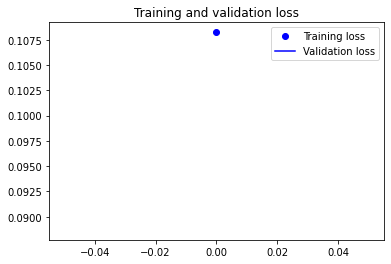

In [17]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [18]:
pred = autoencoder.predict(test_images)
pred.shape


(10000, 28, 28, 1)

Test Images


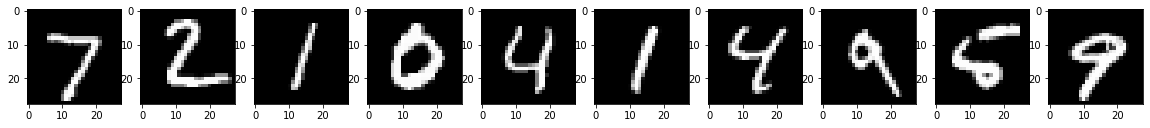

Reconstruction of Test Images


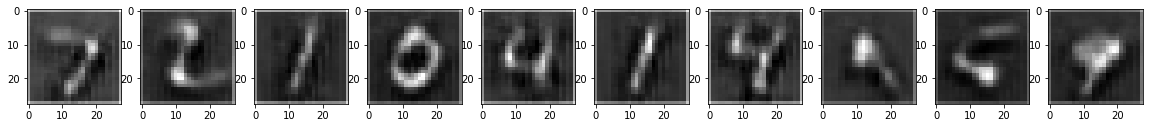

In [19]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(test_images[i, ..., 0], cmap='gray')
    curr_lbl = test_labels[i]
    #plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

In [20]:
# Freeze the layers 
for layer in autoencoder.layers[:-5]:
    print(layer.name)
    layer.trainable = False

input_1
conv2d
max_pooling2d
conv2d_1
max_pooling2d_1
conv3


In [21]:
flat = Flatten()(conv3)

In [22]:
output = Dense(10,activation='softmax')(flat)
encoder = Model(input_img,output)
encoder.compile(optimizer='adam',loss='categorical_crossentropy',
                    metrics=['accuracy'])
encoder.summary()
encoder.fit(train_images,to_categorical(train_labels),epochs=1,batch_size=32)
score = encoder.evaluate(test_images, to_categorical(test_labels), verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 4)         40        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 4)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         296       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                             
                                                                 
 conv3 (Conv2D)              (None, 7, 7, 16)          1168